### Imporitng Libraries

In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,START,END
from dotenv import load_dotenv
from typing import Annotated,TypedDict
import operator
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate

### Loading Environment & Initializing Model

In [2]:
load_dotenv()
model=ChatOpenAI(model="gpt-4o-mini")

### Pydantic Model for Structured Output

In [3]:
class EvaluateSchema(BaseModel):
    feedback:Annotated[str,Field(description="Detailed Feedback of blog")]
    score:Annotated[int,Field(description="This is the score out of 10",gt=0,le=10)]

In [4]:
StructuredModel=model.with_structured_output(EvaluateSchema)

### Defining the Blog Evaluation State

In [5]:
class BlogEvaluationState(TypedDict):
    blog:str

    clarity_structure_feedback:str
    engagement_value_feedback:str
    credibility_depth_feedback:str
    overall_feedback:str

    individual_score:Annotated[list[int],operator.add]
    final_score:float

In [6]:
graph=StateGraph(BlogEvaluationState)

### Node 1 for Clarity and Structure Feedback

In [7]:
def gen_clarity_structure_feedback(state:BlogEvaluationState)->BlogEvaluationState:
    blog=state["blog"]
    template=PromptTemplate(
        template="""You have to act as a professional Content Reviewer. You will be given the blog and you have to check only for the clarity and structure of the blog.
        You have to check Following thing to ensure Clarity and Structure.
        1. A compelling headline
        2. Clear introduction, body, and conclusion
        3. Well-organized sections
    Based on that you have to give appropraite feedback and score between 1 to 10. The blog is given below:
    Blog: {blog}
    """,
    input_variables=["blog"]
    )
    prompt=template.invoke({"blog":blog})
    response=StructuredModel.invoke(prompt)
    return {
        "clarity_structure_feedback":response.feedback,
        "individual_score":[response.score]
    }
graph.add_node("gen_clarity_structure_feedback",gen_clarity_structure_feedback)

### Node 2 for Engagement and Value Feedback

In [8]:
def gen_engagement_value_feedback(state:BlogEvaluationState)->BlogEvaluationState:
    blog=state["blog"]
    template=PromptTemplate(
        template="""You have to act as a professional Content Reviewer. You will be given the blog and you have to check only for the Engagement and Value of the blog.
        You have to check Following thing to ensure Engagement and Value. 
        1. Solves a problem, answers a question, or offers a fresh perspective
        2. Uses examples, or storytelling to maintain engagement
        3. Has a conversational or audience-appropriate tone
    Based on that you have to give appropraite feedback and score between 1 to 10. The blog is given below:
    Blog: {blog}
    """,
    input_variables=["blog"]
    )
    prompt=template.invoke({"blog":blog})
    response=StructuredModel.invoke(prompt)
    return {
        "engagement_value_feedback":response.feedback,
        "individual_score":[response.score]
    }
graph.add_node("gen_engagement_value_feedback",gen_engagement_value_feedback)

### Node 3 for Credibility and Depth Feedback

In [9]:
def gen_credibility_depth_feedback(state:BlogEvaluationState)->BlogEvaluationState:
    blog=state["blog"]
    template=PromptTemplate(
        template="""You have to act as a professional Content Reviewer. You will be given the blog and you have to check only for the Credability and Depth of the blog.
        You have to check Following thing to ensure Credibility and Depth.
        1. Includes accurate information or data
        2. Shows depth of understanding, not just surface-level content
    Based on that you have to give appropraite feedback and score between 1 to 10. The blog is given below:
    Blog: {blog}
    """,
    input_variables=["blog"]
    )
    prompt=template.invoke({"blog":blog})
    response=StructuredModel.invoke(prompt)
    return {
        "credibility_depth_feedback":response.feedback,
        "individual_score":[response.score]
    }
graph.add_node("gen_credibility_depth_feedback",gen_credibility_depth_feedback)

### Node 4 for Overall Feedback

In [10]:
def gen_overall_feedback(state:BlogEvaluationState)->BlogEvaluationState:
    clarity_structure_feedback=state["clarity_structure_feedback"]
    engagement_value_feedback=state["engagement_value_feedback"]
    credibility_depth_feedback=state["credibility_depth_feedback"]
    template=PromptTemplate(
        template="""You will be given 3 different feedbacks of a Blog. One is Clarity and Structure Feedback, Second is Engagement and Value Feedback and Third is Credibility and Depth Feedack.
        You have to write a summerized feedback that tell the issues and measures that a content writer can take to improve that blog.
        The feedbacks are as follows:
        Clarity and Structure Feedback: {clarity_structure_feedback}
        Engagement and Value Feedback:  {engagement_value_feedback}
        Credibility and Depth Feedack:  {credibility_depth_feedback}
    """,
    input_variables=["clarity_structure_feedback","engagement_value_feedback","credibility_depth_feedback"]
    )
    prompt=template.invoke({
        "clarity_structure_feedback":clarity_structure_feedback,
        "engagement_value_feedback":engagement_value_feedback,
        "credibility_depth_feedback":credibility_depth_feedback
    })
    response=model.invoke(prompt)
    score=(sum(state["individual_score"]))/len(state['individual_score'])
    return {
        "overall_feedback":response.content,
        "final_score":score
    }
graph.add_node("gen_overall_feedback",gen_overall_feedback)

### Defining Graph Edges

In [11]:
graph.add_edge(START,"gen_clarity_structure_feedback")
graph.add_edge(START,"gen_engagement_value_feedback")
graph.add_edge(START,"gen_credibility_depth_feedback")

graph.add_edge("gen_clarity_structure_feedback","gen_overall_feedback")
graph.add_edge("gen_engagement_value_feedback","gen_overall_feedback")
graph.add_edge("gen_credibility_depth_feedback","gen_overall_feedback")

graph.add_edge("gen_overall_feedback",END)

### Compiling Graph

In [12]:
workflow=graph.compile()

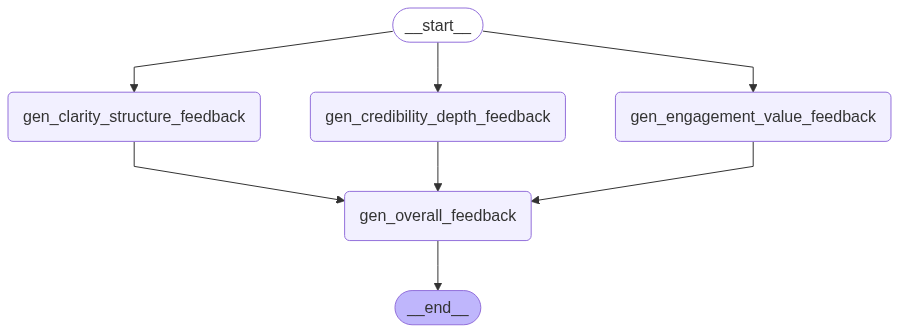

In [13]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [14]:
blog="""Poverty in Pakistan is a pressing socio-economic issue, deeply rooted in structural inequalities and systemic barriers. Despite economic progress and numerous development initiatives, a significant portion of the Pakistani population continues to live below the poverty line, deprived of basic necessities such as adequate nutrition, education, and healthcare.

One of the primary reasons for persistent poverty in Pakistan is income inequality. Wealth distribution is highly skewed, with the richest segments controlling significant resources while vast numbers struggle with minimal income. The rural population, particularly in provinces like Balochistan and Sindh, is disproportionately affected, facing limited access to economic opportunities and public services.

Educational disparity is another critical factor contributing to poverty. Limited access to quality education reduces the potential for upward mobility, perpetuating cycles of poverty across generations. Many children from impoverished families either receive no formal education or attend severely underfunded schools, limiting their chances of securing stable, well-paying jobs in adulthood.

Healthcare inequality further exacerbates the issue, with poor communities experiencing limited access to quality healthcare facilities. Malnutrition, infectious diseases, and insufficient healthcare services contribute to higher mortality rates and lower life expectancy among the poor, further entrenching economic instability.

Government initiatives, such as the Benazir Income Support Programme (BISP) and Ehsaas Program, have aimed to alleviate poverty through cash transfers and social support. However, structural challenges, including corruption, bureaucratic inefficiencies, and inadequate funding, often limit their effectiveness.

Addressing poverty in Pakistan requires a multi-dimensional approach: increasing investment in education, improving healthcare infrastructure, promoting equitable economic opportunities, and enhancing governance and transparency. Only through sustained, inclusive growth and targeted interventions can Pakistan hope to significantly reduce poverty and foster economic justice for all citizens.

"""

In [15]:
final_state=workflow.invoke({
    "blog":blog
})

In [16]:
final_state['final_score']

7.0

In [17]:
from IPython.display import Markdown, display

display(Markdown(final_state['overall_feedback']))


**Summarized Feedback for Blog Improvement:**

The blog addressing poverty in Pakistan serves as a valuable resource but could benefit from several enhancements to improve clarity, engagement, and credibility. 

1. **Compelling Headline and Engaging Introduction**: Start with a more captivating headline, such as "Confronting Poverty in Pakistan: Challenges and Solutions," to better attract readers. Additionally, the introduction should be slightly more engaging to draw readers in, potentially by posing a thought-provoking question or sharing a striking statistic related to poverty.

2. **Stronger Conclusion**: The blog should include a clearer conclusion that summarizes the key points discussed and effectively reinforces the call to action. This will help leave a lasting impression on the readers and encourage them to reflect on the issue.

3. **Use of Subheadings**: Incorporating subheadings will improve the blog's organization and readability. This will allow readers to navigate easily through different sections, enhancing their overall experience.

4. **Personal Stories and Conversational Tone**: To increase engagement, consider adding personal stories or real-life examples that illustrate the impact of poverty on communities. Adopting a more conversational tone can also make the content accessible to a wider audience beyond just academics or policymakers.

5. **Supporting Data and Statistics**: To bolster credibility, include current statistics or data that support the claims made in the blog. This will not only enhance the depth of the analysis but also provide concrete evidence for the arguments presented.

By implementing these measures, the content writer can significantly enhance the blog’s clarity, engagement, and credibility, making it a more powerful tool for raising awareness and addressing poverty in Pakistan.